<div style="float:left">
    <h1 style="width:600px">Objective 2: Regression Models</h1>
</div>
<div style="float:right"><img width="100" src="https://github.com/jreades/i2p/raw/master/img/casa_logo.jpg" /></div>

# 0. Loading Library

In [4]:
import pandas as pd
from sklearn.linear_model import LinearRegression

import numpy as np

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import matplotlib
# import seaborn as sn

from time import time

# 1. Travel time result

## 1.1 Merge Datasets

In [7]:
import pandas as pd

Walk = pd.read_csv("Travel_time_Result_final/travel_times_WALK_0822.csv")
Transit = pd.read_csv("Travel_time_Result_final/travel_times_TRANSIT_0822.csv")
Walk_and_Transit = pd.read_csv("Travel_time_Result_final/travel_times_BOTH_0822.csv")
Car = pd.read_csv("Travel_time_Result_final/travel_times_CAR_0822.csv")
Bicycle = pd.read_csv("Travel_time_Result_final/travel_times_BICYCLE_0822.csv")

In [8]:
import pandas as pd

# First, merge Walk and Transit
merged_df = pd.merge(
    Walk[['FID', 'LSOA21CD', 'LSOA21NM', 'BNG_E', 'BNG_N', 'LONG', 'LAT', 'GlobalID', 'geometry', 'id', 'from_id', 'to_id', 'travel_time']],
    Transit[['from_id', 'to_id', 'travel_time']],
    on=['from_id', 'to_id'],
    suffixes=('_Walk', '_Transit')
)

# Then sequentially merge Walk_and_Transit, Car, Bicycle
merged_df = pd.merge(
    merged_df,
    Walk_and_Transit[['from_id', 'to_id', 'travel_time']],
    on=['from_id', 'to_id'],
    how='left'
).rename(columns={'travel_time': 'Walk_and_Transit_travel_time'})

merged_df = pd.merge(
    merged_df,
    Car[['from_id', 'to_id', 'travel_time']],
    on=['from_id', 'to_id'],
    how='left'
).rename(columns={'travel_time': 'Car_travel_time'})

merged_df = pd.merge(
    merged_df,
    Bicycle[['from_id', 'to_id', 'travel_time']],
    on=['from_id', 'to_id'],
    how='left'
).rename(columns={'travel_time': 'Bicycle_travel_time'})

# Rename the columns from the final merge
merged_df = merged_df.rename(columns={'travel_time_Walk': 'Walk_travel_time', 'travel_time_Transit': 'Transit_travel_time'})

In [9]:
merged_df.head(2)

,FID,LSOA21CD,LSOA21NM,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry,id,from_id,to_id,Walk_travel_time,Transit_travel_time,Walk_and_Transit_travel_time,Car_travel_time,Bicycle_travel_time
0,1,E01000001,City of London 001A,532123,181632,-0.09714,51.51816,c0565620-19c9-46e4-aea5-7031bb89b7d2,"POLYGON ((532151.5375 181867.433499999, 532152...",1,1,183,10.0,10.0,10.0,4,8
1,2,E01000002,City of London 001B,532480,181715,-0.09197,51.51882,6aac6ffa-0cca-4aec-9a0a-1eeace1ea636,"POLYGON ((532634.497 181926.016000001, 532632....",2,2,183,7.0,7.0,7.0,2,5


## 1.2 Check the difference between "WALK.MODE" and "TRANSIT.MODE"

In [11]:
import pandas as pd

# Assuming merged_df DataFrame already contains all merged data

# Create boolean columns indicating whether the two columns are the same
merged_df['Walk_vs_Transit'] = merged_df['Walk_travel_time'] == merged_df['Transit_travel_time']
merged_df['Walk_vs_Walk_and_Transit'] = merged_df['Walk_travel_time'] == merged_df['Walk_and_Transit_travel_time']
merged_df['Transit_vs_Walk_and_Transit'] = merged_df['Transit_travel_time'] == merged_df['Walk_and_Transit_travel_time']

# Extract rows where the two columns are different, generating new DataFrames
diff_walk_transit = merged_df[~merged_df['Walk_vs_Transit']].copy()
diff_walk_walk_and_transit = merged_df[~merged_df['Walk_vs_Walk_and_Transit']].copy()
diff_transit_walk_and_transit = merged_df[~merged_df['Transit_vs_Walk_and_Transit']].copy()

# Drop the boolean columns since they were only used for comparison
diff_walk_transit.drop(columns=['Walk_vs_Transit', 'Walk_vs_Walk_and_Transit', 'Transit_vs_Walk_and_Transit'], inplace=True)
diff_walk_walk_and_transit.drop(columns=['Walk_vs_Transit', 'Walk_vs_Walk_and_Transit', 'Transit_vs_Walk_and_Transit'], inplace=True)
diff_transit_walk_and_transit.drop(columns=['Walk_vs_Transit', 'Walk_vs_Walk_and_Transit', 'Transit_vs_Walk_and_Transit'], inplace=True)

In [12]:
# Display the number of different rows and the first few rows of the generated DataFrame
print(f"Number of different rows between Walk and Transit modes: {len(diff_walk_transit)}")

diff_walk_transit.head(2)

Number of different rows between Walk and Transit modes: 202


,FID,LSOA21CD,LSOA21NM,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry,id,from_id,to_id,Walk_travel_time,Transit_travel_time,Walk_and_Transit_travel_time,Car_travel_time,Bicycle_travel_time
33,34,E01000038,Barking and Dagenham 003C,550700,187149,0.172761,51.56309,fa864750-afff-44f5-8357-b1a4404f4026,"POLYGON ((550920.362 187341.138, 550921.876 18...",34,34,282,48.0,43.0,43.0,8,19
215,216,E01000228,Barnet 007A,521213,194146,-0.249990,51.63307,728f20bf-3abe-4835-ab44-75e08ac4cf18,"POLYGON ((520025.219 195196.687000001, 520049....",216,216,314,43.0,35.0,35.0,5,18


In [13]:
print(f"Number of different rows between Walk and Walk_and_Transit modes: {len(diff_walk_walk_and_transit)}")

diff_walk_walk_and_transit.head(2)

Number of different rows between Walk and Walk_and_Transit modes: 202


,FID,LSOA21CD,LSOA21NM,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry,id,from_id,to_id,Walk_travel_time,Transit_travel_time,Walk_and_Transit_travel_time,Car_travel_time,Bicycle_travel_time
33,34,E01000038,Barking and Dagenham 003C,550700,187149,0.172761,51.56309,fa864750-afff-44f5-8357-b1a4404f4026,"POLYGON ((550920.362 187341.138, 550921.876 18...",34,34,282,48.0,43.0,43.0,8,19
215,216,E01000228,Barnet 007A,521213,194146,-0.249990,51.63307,728f20bf-3abe-4835-ab44-75e08ac4cf18,"POLYGON ((520025.219 195196.687000001, 520049....",216,216,314,43.0,35.0,35.0,5,18


In [14]:
print(f"Number of different rows between Transit and Walk_and_Transit modes: {len(diff_transit_walk_and_transit)}")

diff_transit_walk_and_transit.head(5)

Number of different rows between Transit and Walk_and_Transit modes: 3


,FID,LSOA21CD,LSOA21NM,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry,id,from_id,to_id,Walk_travel_time,Transit_travel_time,Walk_and_Transit_travel_time,Car_travel_time,Bicycle_travel_time
1363,1364,E01001418,Enfield 011C,528746,196116,-0.140480,51.64910,c9f3d23c-e355-4b59-872e-5b151a751eab,"POLYGON ((528987.426 196489.257999999, 528990....",1364,1364,333,NaN,NaN,NaN,3,9
2636,2637,E01002775,Islington 014D,532336,184986,-0.092810,51.54825,e8d170fa-b982-4d09-b92b-8b2644096c5b,"POLYGON ((532211.796 185057.685000001, 532209....",2637,2637,229,NaN,NaN,NaN,5,10
4847,32517,E01034478,Barking and Dagenham 019I,547576,182291,0.125691,51.52026,1d6afc44-40b3-41ad-8537-ad5139df2a13,"POLYGON ((547525 182987, 547548.97 182981.1300...",32517,32517,169,NaN,NaN,NaN,38,90


In [15]:
merged_df.head(2)

,FID,LSOA21CD,LSOA21NM,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry,id,from_id,to_id,Walk_travel_time,Transit_travel_time,Walk_and_Transit_travel_time,Car_travel_time,Bicycle_travel_time,Walk_vs_Transit,Walk_vs_Walk_and_Transit,Transit_vs_Walk_and_Transit
0,1,E01000001,City of London 001A,532123,181632,-0.09714,51.51816,c0565620-19c9-46e4-aea5-7031bb89b7d2,"POLYGON ((532151.5375 181867.433499999, 532152...",1,1,183,10.0,10.0,10.0,4,8,True,True,True
1,2,E01000002,City of London 001B,532480,181715,-0.09197,51.51882,6aac6ffa-0cca-4aec-9a0a-1eeace1ea636,"POLYGON ((532634.497 181926.016000001, 532632....",2,2,183,7.0,7.0,7.0,2,5,True,True,True


In [16]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4994 entries, 0 to 4993
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   FID                           4994 non-null   int64  
 1   LSOA21CD                      4994 non-null   object 
 2   LSOA21NM                      4994 non-null   object 
 3   BNG_E                         4994 non-null   int64  
 4   BNG_N                         4994 non-null   int64  
 5   LONG                          4994 non-null   float64
 6   LAT                           4994 non-null   float64
 7   GlobalID                      4994 non-null   object 
 8   geometry                      4994 non-null   object 
 9   id                            4994 non-null   int64  
 10  from_id                       4994 non-null   int64  
 11  to_id                         4994 non-null   int64  
 12  Walk_travel_time              4990 non-null   float64
 13  Tra

# 2. Social-economic factors

## 2.1 Level_4 (Qualifications)

In [19]:
import pandas as pd

Qualifications = pd.read_csv("Dataset/Qualifications, Disability, Health and Care/Qualifications.csv")

In [20]:
Qualifications_percentage = Qualifications.copy()

In [21]:
# Assuming pandas has already been imported
import pandas as pd

# Assuming df is your DataFrame
# Calculate the percentage and replace the original values
columns_to_convert = ['none', 'Level 1', 'Level 2', 'Apprenticeship', 'Level 3', 'Level 4+', 'Other']
Qualifications_percentage[columns_to_convert] = Qualifications_percentage[columns_to_convert].div(Qualifications_percentage['Usual residents aged 16+'], axis=0) * 100


## 2.2 Employment rate

In [23]:
import pandas as pd

Economic_activity_status = pd.read_csv("Dataset/Labour market/Economic activity status_custom-filtered.csv")

In [24]:
# Combine the values of the 'Economic activity status (7 categories) Code' and 'Economic activity status (7 categories)' columns
Economic_activity_status['economic_activity_status'] = (
    Economic_activity_status['Economic activity status (7 categories) Code'].astype(str) + 
    '_' + 
    Economic_activity_status['Economic activity status (7 categories)']
)

In [25]:
# Drop the 'Economic activity status (7 categories) Code' and 'Economic activity status (7 categories)' columns
Economic_activity_status = Economic_activity_status.drop(columns=[
    'Economic activity status (7 categories) Code', 
    'Economic activity status (7 categories)'
])

In [26]:
Economic_activity_status.head(2)

,Lower layer Super Output Areas Code,Lower layer Super Output Areas,Observation,economic_activity_status
0,E01000001,City of London 001A,125,-8_Does not apply
1,E01000001,City of London 001A,856,1_Economically active (excluding full-time stu...


In [27]:
# Use pivot_table to convert the values in the economic_activity_status column into new column names and populate these columns with the Observation values
economic_activity = Economic_activity_status.pivot_table(
    index=['Lower layer Super Output Areas Code', 'Lower layer Super Output Areas'],
    columns='economic_activity_status',
    values='Observation',
    fill_value=0
).reset_index()

In [28]:
economic_activity.head(2)

economic_activity_status,Lower layer Super Output Areas Code,Lower layer Super Output Areas,-8_Does not apply,1_Economically active (excluding full-time students): In employment,2_Economically active (excluding full-time students): Unemployed: Seeking work or waiting to start a job already obtained: Available to start working within 2 weeks,3_Economically active and a full-time student: In employment,4_Economically active and a full-time student: Unemployed: Seeking work or waiting to start a job already obtained: Available to start working within 2 weeks,5_Economically inactive (excluding full-time students),6_Economically inactive and a full-time student
0,E01000001,City of London 001A,125.0,856.0,32.0,10.0,6.0,373.0,76.0
1,E01000002,City of London 001B,86.0,870.0,30.0,8.0,3.0,301.0,85.0


In [29]:
# Change column name to 'Index'
economic_activity.columns.name = 'Index'

In [30]:
# Define the column names to be summed
columns_to_sum = [
    '-8_Does not apply',
    '1_Economically active (excluding full-time students): In employment',
    '2_Economically active (excluding full-time students): Unemployed: Seeking work or waiting to start a job already obtained: Available to start working within 2 weeks',
    '3_Economically active and a full-time student: In employment',
    '4_Economically active and a full-time student: Unemployed: Seeking work or waiting to start a job already obtained: Available to start working within 2 weeks',
    '5_Economically inactive (excluding full-time students)',
    '6_Economically inactive and a full-time student'
]

# Create a new column 'total_population', which is the sum of the above seven columns
economic_activity['total_population'] = economic_activity[columns_to_sum].sum(axis=1)

In [31]:
economic_activity.head(2)

Index,Lower layer Super Output Areas Code,Lower layer Super Output Areas,-8_Does not apply,1_Economically active (excluding full-time students): In employment,2_Economically active (excluding full-time students): Unemployed: Seeking work or waiting to start a job already obtained: Available to start working within 2 weeks,3_Economically active and a full-time student: In employment,4_Economically active and a full-time student: Unemployed: Seeking work or waiting to start a job already obtained: Available to start working within 2 weeks,5_Economically inactive (excluding full-time students),6_Economically inactive and a full-time student,total_population
0,E01000001,City of London 001A,125.0,856.0,32.0,10.0,6.0,373.0,76.0,1478.0
1,E01000002,City of London 001B,86.0,870.0,30.0,8.0,3.0,301.0,85.0,1383.0


In [32]:
employment_rate_columns = [
    'Lower layer Super Output Areas Code',
    'Lower layer Super Output Areas',
    '1_Economically active (excluding full-time students): In employment',
    'total_population' 
]

In [33]:
employment_rate = economic_activity[employment_rate_columns] 

In [34]:
employment_rate_copy = employment_rate.copy()

In [35]:
employment_rate_copy['employment_rate'] = employment_rate['1_Economically active (excluding full-time students): In employment'].div(employment_rate['total_population'], axis=0) * 100

In [36]:
employment_rate_copy.head(2)

Index,Lower layer Super Output Areas Code,Lower layer Super Output Areas,1_Economically active (excluding full-time students): In employment,total_population,employment_rate
0,E01000001,City of London 001A,856.0,1478.0,57.916103
1,E01000002,City of London 001B,870.0,1383.0,62.906725


# 3. Merge Datasets

In [38]:
merged_df.head(2)

,FID,LSOA21CD,LSOA21NM,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry,id,from_id,to_id,Walk_travel_time,Transit_travel_time,Walk_and_Transit_travel_time,Car_travel_time,Bicycle_travel_time,Walk_vs_Transit,Walk_vs_Walk_and_Transit,Transit_vs_Walk_and_Transit
0,1,E01000001,City of London 001A,532123,181632,-0.09714,51.51816,c0565620-19c9-46e4-aea5-7031bb89b7d2,"POLYGON ((532151.5375 181867.433499999, 532152...",1,1,183,10.0,10.0,10.0,4,8,True,True,True
1,2,E01000002,City of London 001B,532480,181715,-0.09197,51.51882,6aac6ffa-0cca-4aec-9a0a-1eeace1ea636,"POLYGON ((532634.497 181926.016000001, 532632....",2,2,183,7.0,7.0,7.0,2,5,True,True,True


In [39]:
columns_refine = ['FID','LSOA21CD','LSOA21NM','geometry',
                  'from_id','to_id',
                  'Walk_travel_time','Transit_travel_time','Walk_and_Transit_travel_time','Car_travel_time','Bicycle_travel_time']

In [40]:
merged_df_refine = merged_df[columns_refine]

In [41]:
merged_df_refine.head(2)

,FID,LSOA21CD,LSOA21NM,geometry,from_id,to_id,Walk_travel_time,Transit_travel_time,Walk_and_Transit_travel_time,Car_travel_time,Bicycle_travel_time
0,1,E01000001,City of London 001A,"POLYGON ((532151.5375 181867.433499999, 532152...",1,183,10.0,10.0,10.0,4,8
1,2,E01000002,City of London 001B,"POLYGON ((532634.497 181926.016000001, 532632....",2,183,7.0,7.0,7.0,2,5


In [42]:
Qualifications_percentage.head(2)

,LSOA code,local authority code,local authority name,Usual residents aged 16+,none,Level 1,Level 2,Apprenticeship,Level 3,Level 4+,Other
0,E01000001,E09000001,City of London,1353,2.365115,1.921656,3.991131,0.960828,6.356245,83.222469,1.182557
1,E01000002,E09000001,City of London,1300,1.769231,2.153846,4.000000,0.307692,6.846154,83.538462,1.384615


In [43]:
employment_rate_copy.head(2)

Index,Lower layer Super Output Areas Code,Lower layer Super Output Areas,1_Economically active (excluding full-time students): In employment,total_population,employment_rate
0,E01000001,City of London 001A,856.0,1478.0,57.916103
1,E01000002,City of London 001B,870.0,1383.0,62.906725


In [44]:
# Use the merge function of pandas to merge two DataFrames.
Final_df = merged_df_refine.merge(
    Qualifications_percentage[['LSOA code', 'Level 3', 'Level 4+']],
    left_on='LSOA21CD',
    right_on='LSOA code',
    how='left'
)

In [45]:
# Remove duplicate LSOA code columns
Final_df = Final_df.drop(columns=['LSOA code'])

In [46]:
Final_df.head(2)

,FID,LSOA21CD,LSOA21NM,geometry,from_id,to_id,Walk_travel_time,Transit_travel_time,Walk_and_Transit_travel_time,Car_travel_time,Bicycle_travel_time,Level 3,Level 4+
0,1,E01000001,City of London 001A,"POLYGON ((532151.5375 181867.433499999, 532152...",1,183,10.0,10.0,10.0,4,8,6.356245,83.222469
1,2,E01000002,City of London 001B,"POLYGON ((532634.497 181926.016000001, 532632....",2,183,7.0,7.0,7.0,2,5,6.846154,83.538462


In [47]:
# Use the merge function of pandas to merge two DataFrames.
Final_df = Final_df.merge(
    employment_rate_copy[['Lower layer Super Output Areas Code', 'employment_rate']],
    left_on='LSOA21CD',
    right_on='Lower layer Super Output Areas Code',
    how='left'
)

In [48]:
# Delete the `Lower layer Super Output Areas Code' column
Final_df = Final_df.drop(columns=['Lower layer Super Output Areas Code'])

In [49]:
Final_df = Final_df.rename(columns = {'Level 3':'Level_3','Level 4+':'Level_4',})

In [50]:
Final_df.head(2)

,FID,LSOA21CD,LSOA21NM,geometry,from_id,to_id,Walk_travel_time,Transit_travel_time,Walk_and_Transit_travel_time,Car_travel_time,Bicycle_travel_time,Level_3,Level_4,employment_rate
0,1,E01000001,City of London 001A,"POLYGON ((532151.5375 181867.433499999, 532152...",1,183,10.0,10.0,10.0,4,8,6.356245,83.222469,57.916103
1,2,E01000002,City of London 001B,"POLYGON ((532634.497 181926.016000001, 532632....",2,183,7.0,7.0,7.0,2,5,6.846154,83.538462,62.906725


In [51]:
# Filter all rows containing NA values and save to Final_df_NA

Final_df_NA = Final_df[Final_df.isna().any(axis=1)]
Final_df_NA.head()

,FID,LSOA21CD,LSOA21NM,geometry,from_id,to_id,Walk_travel_time,Transit_travel_time,Walk_and_Transit_travel_time,Car_travel_time,Bicycle_travel_time,Level_3,Level_4,employment_rate
1363,1364,E01001418,Enfield 011C,"POLYGON ((528987.426 196489.257999999, 528990....",1364,333,NaN,NaN,NaN,3,9,14.574616,41.352859,42.701149
2330,2331,E01002444,Hillingdon 031A,"POLYGON ((505791.209 178363.541999999, 505784....",2331,77,NaN,89.0,89.0,25,51,10.301508,30.213568,46.726505
2636,2637,E01002775,Islington 014D,"POLYGON ((532211.796 185057.685000001, 532209....",2637,229,NaN,NaN,NaN,5,10,10.858995,68.800648,62.855114
4847,32517,E01034478,Barking and Dagenham 019I,"POLYGON ((547525 182987, 547548.97 182981.1300...",32517,169,NaN,NaN,NaN,38,90,13.317757,59.813084,57.429048


# 4. Analysis

In [53]:
df_analysis_columns = ['Walk_and_Transit_travel_time','Car_travel_time','Bicycle_travel_time', 'Level_4','employment_rate']

In [54]:
df_analysis = Final_df[df_analysis_columns]

In [55]:
df_analysis.shape

(4994, 5)

In [56]:
# Use the describe() function for statistical description
stats = df_analysis.describe()

# If you want to include all statistical information for employment_rate, you can use the following code:
stats_all = df_analysis[['Walk_and_Transit_travel_time', 'Car_travel_time', 'Bicycle_travel_time', 'Level_4', 'employment_rate']].describe()

print(stats_all)

       Walk_and_Transit_travel_time  Car_travel_time  Bicycle_travel_time  \
count                   4991.000000      4994.000000          4994.000000   
mean                      18.280505         4.257509             8.617141   
std                        9.774997         2.505865             5.216751   
min                        0.000000         0.000000             0.000000   
25%                       12.000000         3.000000             5.000000   
50%                       17.000000         4.000000             8.000000   
75%                       23.000000         5.000000            11.000000   
max                       89.000000        38.000000            90.000000   

           Level_4  employment_rate  
count  4994.000000      4994.000000  
mean     46.789109        48.183039  
std      13.845567         7.434876  
min      20.216049        21.624629  
25%      35.336862        43.461633  
50%      44.772177        47.514232  
75%      57.214125        52.077982  
ma

# 5. Correlation Martix

In [58]:
df_analysis = df_analysis.dropna()

In [59]:
df_analysis.corr()

,Walk_and_Transit_travel_time,Car_travel_time,Bicycle_travel_time,Level_4,employment_rate
Walk_and_Transit_travel_time,1.000000,0.710459,0.841661,-0.158248,-0.086106
Car_travel_time,0.710459,1.000000,0.636005,-0.026568,-0.001127
Bicycle_travel_time,0.841661,0.636005,1.000000,-0.080071,-0.045383
Level_4,-0.158248,-0.026568,-0.080071,1.000000,0.728634
employment_rate,-0.086106,-0.001127,-0.045383,0.728634,1.000000


In [60]:
df_analysis.corr(method='pearson')

,Walk_and_Transit_travel_time,Car_travel_time,Bicycle_travel_time,Level_4,employment_rate
Walk_and_Transit_travel_time,1.000000,0.710459,0.841661,-0.158248,-0.086106
Car_travel_time,0.710459,1.000000,0.636005,-0.026568,-0.001127
Bicycle_travel_time,0.841661,0.636005,1.000000,-0.080071,-0.045383
Level_4,-0.158248,-0.026568,-0.080071,1.000000,0.728634
employment_rate,-0.086106,-0.001127,-0.045383,0.728634,1.000000


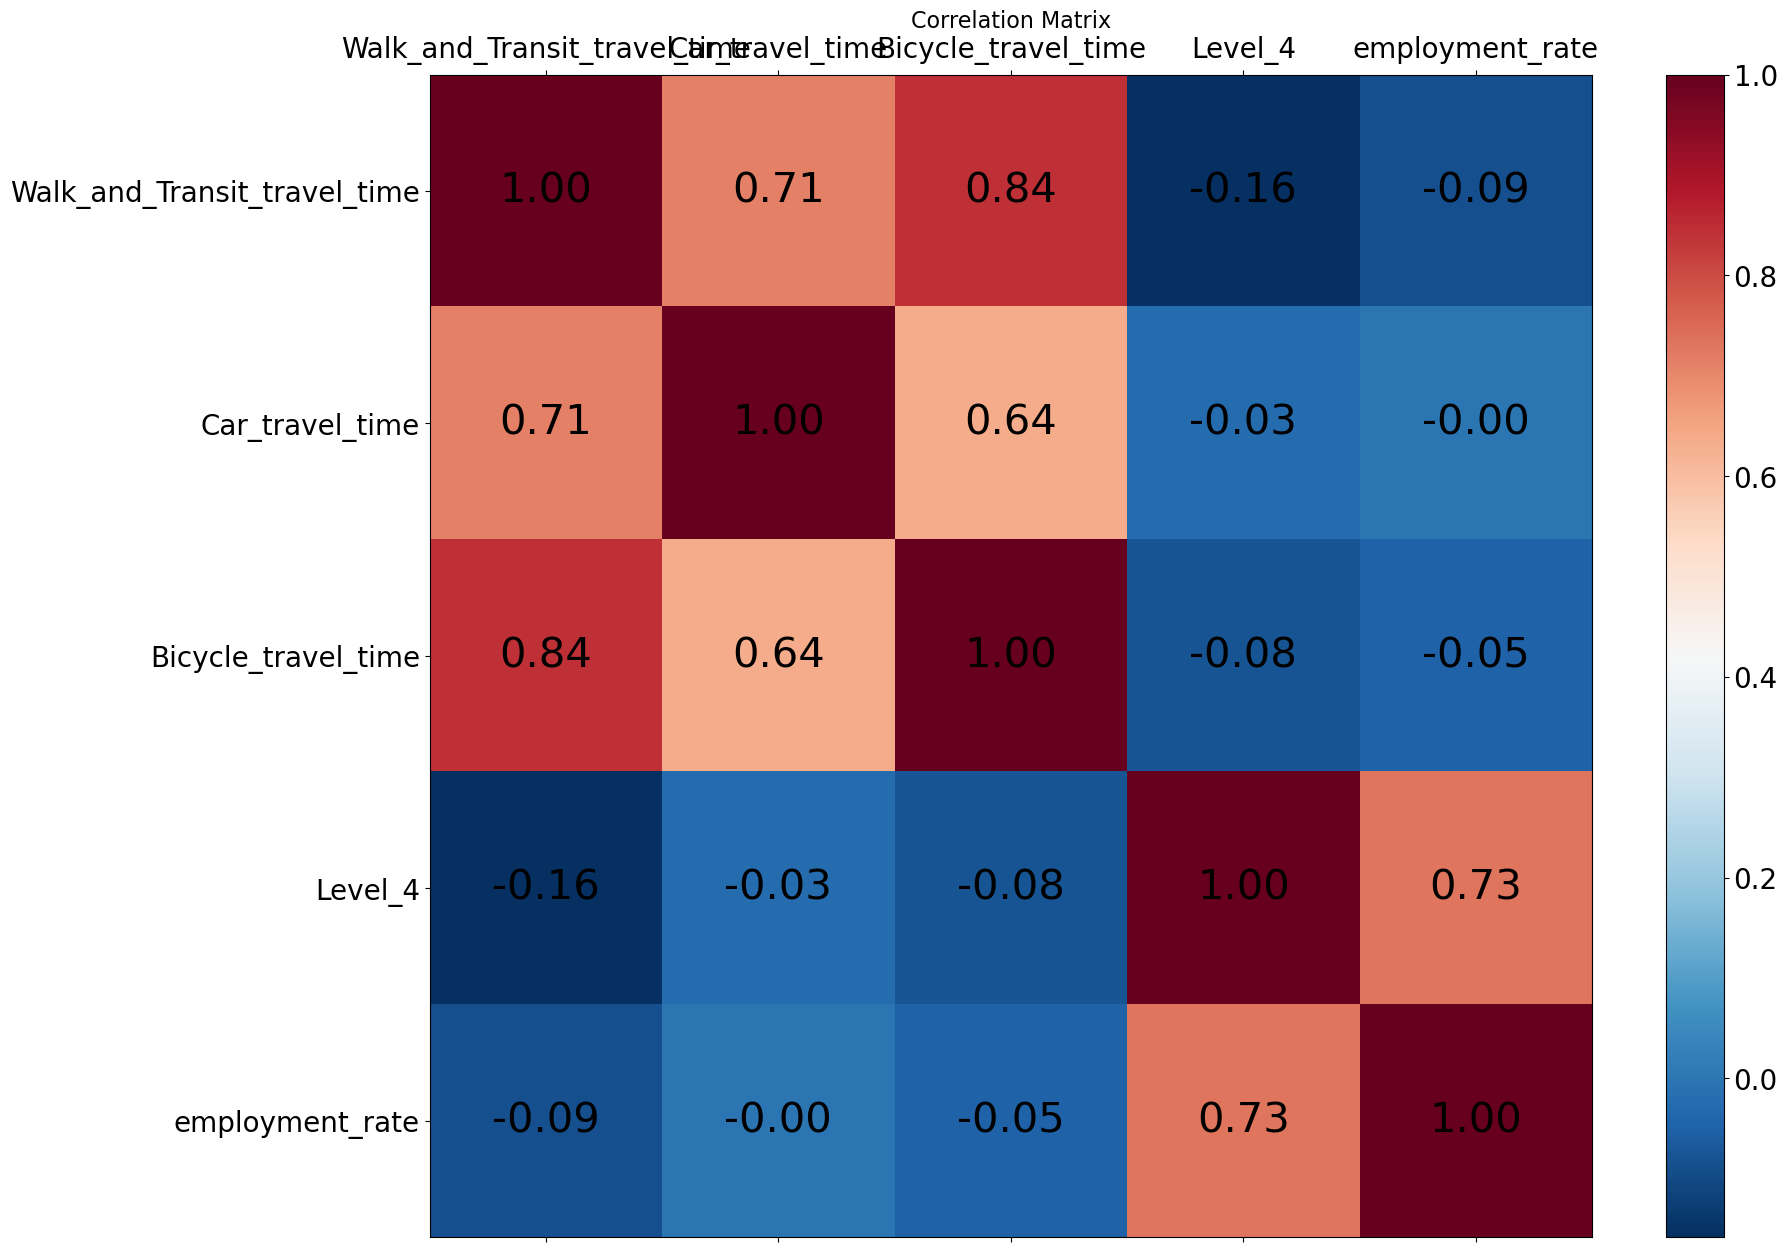

In [61]:
import numpy as np
import matplotlib.pyplot as plt

df = df_analysis
plt.rcParams["axes.grid"] = False
f = plt.figure(figsize=(19, 15))

# Plot the correlation matrix with a 'coolwarm' color map
corr_matrix = df.corr()
plt.matshow(corr_matrix, fignum=f.number, cmap='RdBu_r')

# Add a color bar using the same color map as the heatmap
cb = plt.colorbar()
cb.ax.tick_params(labelsize=20)

# Add tick labels
plt.xticks(range(df.shape[1]), df.columns, fontsize=20, rotation=0)
plt.yticks(range(df.shape[1]), df.columns, fontsize=20)

# Add the correlation coefficient values to each cell
for (i, j), val in np.ndenumerate(corr_matrix.values):
    plt.text(j, i, f'{val:.2f}', ha='center', va='center', fontsize=30, color='black')

# Add a title
plt.title('Correlation Matrix', fontsize=16)

# Save the image as a PNG file
plt.savefig('Plot/correlation_matrix_improved.png', format='png', dpi=300, bbox_inches='tight')

# Display the chart
plt.show()